# 運動方程式を解く
\begin{align}
m\frac{d^2{\bf x}}{dt^2}={\bf F}
\end{align}
重力
\begin{align}
{\bf F}=-mg\hat{z}
\end{align}
を考える。全体を質量$m$で割って
\begin{align}
\frac{d^2{\bf x}}{dt^2}=-g\hat{z}
\end{align}
$x$-$z$平面に問題を限定し、初期位置を原点にとる。初速度はパラメータとし、極座標$(v_{r0},v_{\theta0})$で表す。この方程式の解は、
\begin{align}
x(t) &= v_{r0}*\cos(v_{\theta0})t \nonumber\\
z(t) &= v_{r0}*\sin(v_{\theta0})t-\frac{1}{2}gt^2
\end{align}
となる。

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import clear_output

ImportError: Traceback (most recent call last):
  File "/home/daichi_morita/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/daichi_morita/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/daichi_morita/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/home/daichi_morita/anaconda3/envs/tf/lib/python3.6/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/home/daichi_morita/anaconda3/envs/tf/lib/python3.6/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: libcuda.so.1: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [3]:
class PlotLosses:
    def __init__(self):
        self.i = 0
        self.x = []
        self.losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def update(self, loss, epoch=None, log=True):
        self.x.append(self.i)
        self.losses.append(loss)
        if epoch is None:
            self.i += 1
        else:
            self.i = epoch
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        if log:
            plt.yscale("log")
        plt.xlabel("iteration")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

In [4]:
class Solver:
    def __init__(self, t_f, v0_x_f, v0_z_f, layers):
        assert len(t_f) == len(v0_x_f) == len(v0_z_f)
        
        self.t0 = np.zeros([len(t_f), 1])
        
        self.t_f = np.expand_dims(t_f, axis=1)
        self.v0_x = np.expand_dims(v0_x_f, axis=1)
        self.v0_z = np.expand_dims(v0_z_f, axis=1)
        
        X = np.concatenate([self.t_f, self.v0_x, self.v0_z], axis=1)
        
        self.lb = X.min(axis=0)
        self.ub = X.max(axis=0)
        
        # Initialize NN
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf Placeholders
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        self.v0_x_tf = tf.placeholder(tf.float32, shape=[None, self.v0_x.shape[1]])
        self.v0_z_tf = tf.placeholder(tf.float32, shape=[None, self.v0_z.shape[1]])
        
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])
        
        # tf Graphs
        self.x_pred, self.z_pred, self.vx_pred, self.vz_pred, _, _ = self.net(self.t0_tf, self.v0_x_tf, self.v0_z_tf)
        self.fx_pred, self.fz_pred = self.net_f(self.t_f_tf, self.v0_x_tf, self.v0_z_tf)
        
        # Loss
        self.loss0 = tf.reduce_mean(tf.square(self.x_pred)) + \
                     tf.reduce_mean(tf.square(self.z_pred)) + \
                     tf.reduce_mean(tf.square(self.v0_x_tf - self.vx_pred)) + \
                     tf.reduce_mean(tf.square(self.v0_z_tf - self.vz_pred)) 
        
        self.loss = tf.reduce_mean(tf.square(self.x_pred)) + \
                    tf.reduce_mean(tf.square(self.z_pred)) + \
                    tf.reduce_mean(tf.square(self.v0_x_tf - self.vx_pred)) + \
                    tf.reduce_mean(tf.square(self.v0_z_tf - self.vz_pred)) + \
                    tf.reduce_mean(tf.square(self.fx_pred)) + \
                    tf.reduce_mean(tf.square(self.fz_pred))
        
        # Optimizer
        self.count = 0
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
        self.plot_losses = PlotLosses()

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net(self, t, v0_x, v0_z):
        X = tf.concat([t, v0_x, v0_z], axis=1)
        
        xz = self.neural_net(X, self.weights, self.biases)
        
        x = xz[:,0:1]
        z = xz[:,1:2]
        
        x_t = tf.gradients(x, t)[0]
        x_tt = tf.gradients(x_t, t)[0]
        
        z_t = tf.gradients(z, t)[0]
        z_tt = tf.gradients(z_t, t)[0]

        return x, z, x_t, z_t, x_tt, z_tt

    def net_f(self, t, v0_x, v0_z):
        _, _, _, _, x_tt, z_tt = self.net(t, v0_x, v0_z)
        g = 9.8
        
        return x_tt, z_tt + g
    
    def callback(self, loss):
        if self.count % 100 == 0:
            elapsed = time.time() - self.start_time
            self.plot_losses.update(loss, self.nIter - 1 + self.count)
            print('L-BFGS-B It: %d, Loss: %.3e, Time: %.2f' % 
                  (self.count, loss, elapsed))
            self.start_time = time.time()
        self.count += 1
        
    def train(self, nIter):
        self.nIter = nIter
        tf_dict = {self.t0_tf: self.t0, self.v0_x_tf: self.v0_x,
                   self.v0_z_tf: self.v0_z,
                   self.t_f_tf: self.t_f}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 100 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                
                self.plot_losses.update(loss_value, it)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
                                                                                                                          
        self.start_time = time.time()
#         self.optimizer.minimize(self.sess, 
#                                 feed_dict = tf_dict,         
#                                 fetches = [self.loss0], 
#                                 loss_callback = self.callback)
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)
        
    def predict(self, t, v0_x, v0_z):
        t = np.expand_dims(t, axis=1)
        v0_x = np.expand_dims(v0_x, axis=1)
        v0_z = np.expand_dims(v0_z, axis=1)
        tf_dict = {self.t0_tf: t, self.v0_x_tf: v0_x, self.v0_z_tf: v0_z}
        
        x = self.sess.run(self.x_pred, tf_dict)
        z = self.sess.run(self.z_pred, tf_dict)
        
        return np.squeeze(x, axis=1), np.squeeze(z, axis=1)

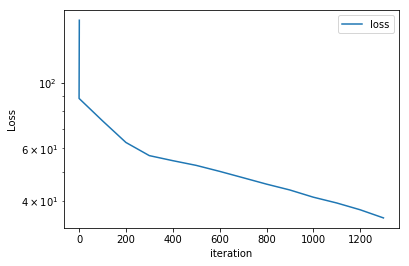

L-BFGS-B It: 1400, Loss: 3.498e+01, Time: 10.41


In [ ]:
N = 10000
t_f = 10 * np.random.rand(N)
v_x0_f = 10 * np.random.rand(N)
v_z0_f = 10 * np.random.rand(N)

plt.axes().set_aspect('equal', 'datalim')
plt.scatter(v_x0_f, v_z0_f, s=1, alpha=0.5)
plt.xlabel("vx")
plt.ylabel("vz")
plt.show()

layers = [20] * 8
layers = [3, *layers, 2]
solver = Solver(t_f, v_x0_f, v_z0_f, layers)
solver.train(0)

In [ ]:
N = 100
t = np.linspace(0, 3, N)
v0_x = 0 * np.ones(N)
v0_z = 5 * np.ones(N)

x, z = solver.predict(t, v0_x, v0_z)

x_exact = v_x0 * t
z_exact = v_z0 * t - 9.8 * t ** 2 / 2

plt.scatter(x, z, s=1)
plt.plot(x_exact, z_exact, alpha=0.5, c="r")
plt.show()

## ToDo
- 初期条件を明示的に与えて解く
- vの関数として解く
- ディリクレ境界条件を課して解く
- LSTMを試す

In [42]:
class Solver:
    def __init__(self, t_f, T, x_T, z_T, layers):
        self.t0 = np.zeros([1, 1])
        self.T = np.expand_dims([T], axis=1)
        self.x_T = np.expand_dims([x_T], axis=1)
        self.z_T = np.expand_dims([z_T], axis=1)
        
        self.t_f = np.expand_dims(t_f, axis=1)
        
        self.lb = self.t_f.min(axis=0)
        self.ub = self.t_f.max(axis=0)
        
        # Initialize NN
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf Placeholders
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        self.T_tf = tf.placeholder(tf.float32, shape=[None, self.T.shape[1]])
        self.x_T_tf = tf.placeholder(tf.float32, shape=[None, self.x_T.shape[1]])
        self.z_T_tf = tf.placeholder(tf.float32, shape=[None, self.z_T.shape[1]])
        
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])
        
        # tf Graphs
        self.x0_pred, self.z0_pred, _, _, _, _ = self.net(self.t0_tf)
        self.x_T_pred, self.z_T_pred, _, _, _, _ = self.net(self.T_tf)
        self.fx_pred, self.fz_pred = self.net_f(self.t_f_tf)
        
        # Loss
        self.loss = tf.reduce_mean(tf.square(self.x0_pred)) + \
                    tf.reduce_mean(tf.square(self.z0_pred)) + \
                    tf.reduce_mean(tf.square(self.x_T_tf - self.x_T_pred)) + \
                    tf.reduce_mean(tf.square(self.z_T_tf - self.z_T_pred)) + \
                    tf.reduce_mean(tf.square(self.fx_pred)) + \
                    tf.reduce_mean(tf.square(self.fz_pred))
        
        # Optimizer
        self.count = 0
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
        self.plot_losses = PlotLosses()

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net(self, t):
        xz = self.neural_net(t, self.weights, self.biases)
        
        x = xz[:,0:1]
        z = xz[:,1:2]
        
        x_t = tf.gradients(x, t)[0]
        x_tt = tf.gradients(x_t, t)[0]
        
        z_t = tf.gradients(z, t)[0]
        z_tt = tf.gradients(z_t, t)[0]

        return x, z, x_t, z_t, x_tt, z_tt

    def net_f(self, t):
        _, _, _, _, x_tt, z_tt = self.net(t)
        g = 9.8
        
        return x_tt, z_tt + g
    
    def callback(self, loss):
        if self.count % 100 == 0:
            elapsed = time.time() - self.start_time
            self.plot_losses.update(loss, self.nIter - 1 + self.count)
            print('L-BFGS-B It: %d, Loss: %.3e, Time: %.2f' % 
                  (self.count, loss, elapsed))
            self.start_time = time.time()
        self.count += 1
        
    def train(self, nIter):
        self.nIter = nIter
        tf_dict = {self.t0_tf: self.t0, self.T_tf: self.T,
                   self.x_T_tf: self.x_T, self.z_T_tf: self.z_T,
                   self.t_f_tf: self.t_f}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 100 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                
                self.plot_losses.update(loss_value, it)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
                                                                                                                          
        self.start_time = time.time()
#         self.optimizer.minimize(self.sess, 
#                                 feed_dict = tf_dict,         
#                                 fetches = [self.loss0], 
#                                 loss_callback = self.callback)
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)
        
    def predict(self, t):
        t = np.expand_dims(t, axis=1)
        tf_dict = {self.t0_tf: t}
        
        x = self.sess.run(self.x0_pred, tf_dict)
        z = self.sess.run(self.z0_pred, tf_dict)
        
        return np.squeeze(x, axis=1), np.squeeze(z, axis=1)

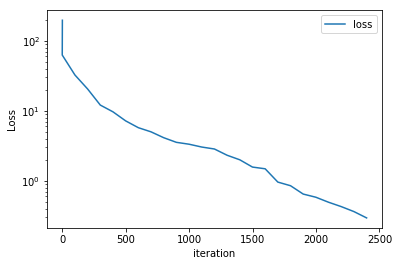

L-BFGS-B It: 2500, Loss: 2.958e-01, Time: 3.76
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.292765
  Number of iterations: 2227
  Number of functions evaluations: 2553


In [47]:
N = 10000
T = 10
x_T = 10
z_T = 0
t_f = np.linspace(0, T, N)

layers = [20] * 8
layers = [1, *layers, 2]
solver = Solver(t_f, T, x_T, z_T, layers)
solver.train(0)

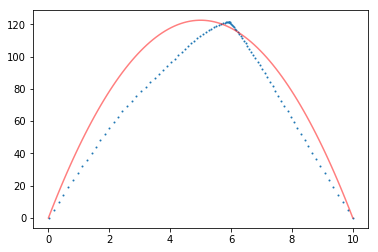

In [48]:
N = 100
t = np.linspace(0, 10, N)

x, z = solver.predict(t)

x_exact = x_T / T * t
z_exact = (z_T / T + 9.8 * T / 2)  * t - 9.8 * t ** 2 / 2

plt.scatter(x, z, s=1)
plt.plot(x_exact, z_exact, alpha=0.5, c="r")
plt.show()